# Imports

In [1]:
# Core
import os
import sys
import re
import datetime as dt
from typing import List, Dict, Tuple, Any, Optional, Union
import logging
from dataclasses import dataclass, field

# Data analysis
import numpy as np
import pandas as pd

# Visalization
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns

# Fitting distributions
import scipy.stats
from fitter import Fitter

from distribution_fitter import *
from utils import *

In [2]:
logging.basicConfig(level=logging.INFO)

# Reading the data

In [3]:
# Helper function to read all the historic dataframes from a path
def read_files(path: str) -> pd.DataFrame:
    files = os.listdir(path)
    files = [os.path.join(path, file) for file in files if re.search(".csv", file)]
    dfs = list(map(lambda file: pd.read_csv(file, low_memory=False), files))
    return pd.concat(dfs)

In [4]:
mlb_df = read_files("../data/MLB/")

In [5]:
mlb_df.columns

Index(['game_info__bigdataball_dataset', 'game_info__game_id',
       'game_info__date', 'player_info__player_id', 'player_info__player_name',
       'player_info__team', 'player_info__opponent', 'player_info__venue',
       'position__draftkings', 'position__fanduel', 'position__yahoo',
       'salary__draftkings', 'salary__fanduel', 'salary__yahoo',
       'fantasy_points__draftkings', 'fantasy_points__fanduel',
       'fantasy_points__yahoo'],
      dtype='object')

In [6]:
mlb_df.dtypes

game_info__bigdataball_dataset     object
game_info__game_id                 object
game_info__date                    object
player_info__player_id            float64
player_info__player_name           object
player_info__team                  object
player_info__opponent              object
player_info__venue                 object
position__draftkings               object
position__fanduel                  object
position__yahoo                    object
salary__draftkings                 object
salary__fanduel                   float64
salary__yahoo                     float64
fantasy_points__draftkings         object
fantasy_points__fanduel            object
fantasy_points__yahoo              object
dtype: object

# Cleaning data

In [7]:
mlb_df.game_info__bigdataball_dataset.value_counts()

game_info__bigdataball_dataset
MLB 2019 Regular Season    71681
MLB 2021 Regular Season    71619
MLB 2022 Regular Season    70931
MLB 2020 Regular Season    26720
MLB 2020 Playoffs           1692
MLB 2021 Playoffs           1213
MLB 2022 Playoffs           1207
MLB 2019 Playoffs           1138
Name: count, dtype: int64

In [8]:
def with_season_type(game_type: str) -> str:
    return "regular-season" if re.search("Season", game_type) else "playoffs"

In [9]:
def format_date(date_str: str) -> dt.datetime:
    try:
        _date = dt.datetime.strptime(date_str, "%d/%m/%Y")
    except ValueError:
        _date = dt.datetime.strptime(date_str, "%m/%d/%Y")
    return _date

In [10]:
cleaned_mlb_df = mlb_df.assign(
    game_info__date=pd.to_datetime(mlb_df.game_info__date.apply(format_date)),
    fantasy_points__draftkings=mlb_df.fantasy_points__draftkings.apply(lambda s: float(str(s).replace(",","."))),
    fantasy_points__fanduel=mlb_df.fantasy_points__fanduel.apply(lambda s: float(str(s).replace(",","."))),
    fantasy_points__yahoo=mlb_df.fantasy_points__yahoo.apply(lambda s: float(str(s).replace(",","."))),
    game_info__game_type=mlb_df.game_info__bigdataball_dataset.apply(with_season_type)
).pipe(lambda df: df.assign(
    year=df['game_info__date'].dt.year
))

# Fitting distributions

## By player

In [11]:
def get_frequencies(df: pd.DataFrame, groupby_keys: List[str]) -> pd.DataFrame:
    frequency_df = df.groupby(groupby_keys).size().reset_index(name='frequency')
    frequency_df = frequency_df.sort_values(by=['frequency'], ascending=False)
    return frequency_df

In [12]:
def plot_distribution_by_variable(df: pd.DataFrame, variable: str, xlabel: str, ylabel: str) -> None:
    
    fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
    
    sns.histplot(data=df, x=variable, kde=True, ax=ax[0])
    ax[0].set_ylabel(ylabel)
    ax[0].set_xlabel(xlabel)
    
    sns.boxplot(data=df, x=variable, orient='h', ax=ax[1])
    sns.stripplot(data=df, x=variable, orient='h', color=".25", ax=ax[1])
    
    ax[1].tick_params(axis='y', which='both', left=False, top=False, labelleft=False)
    ax[1].set_xlabel(xlabel)
    
    fig.suptitle(f'Distribution of: {xlabel.lower()} by {ylabel.lower()}')
    
    plt.plot();

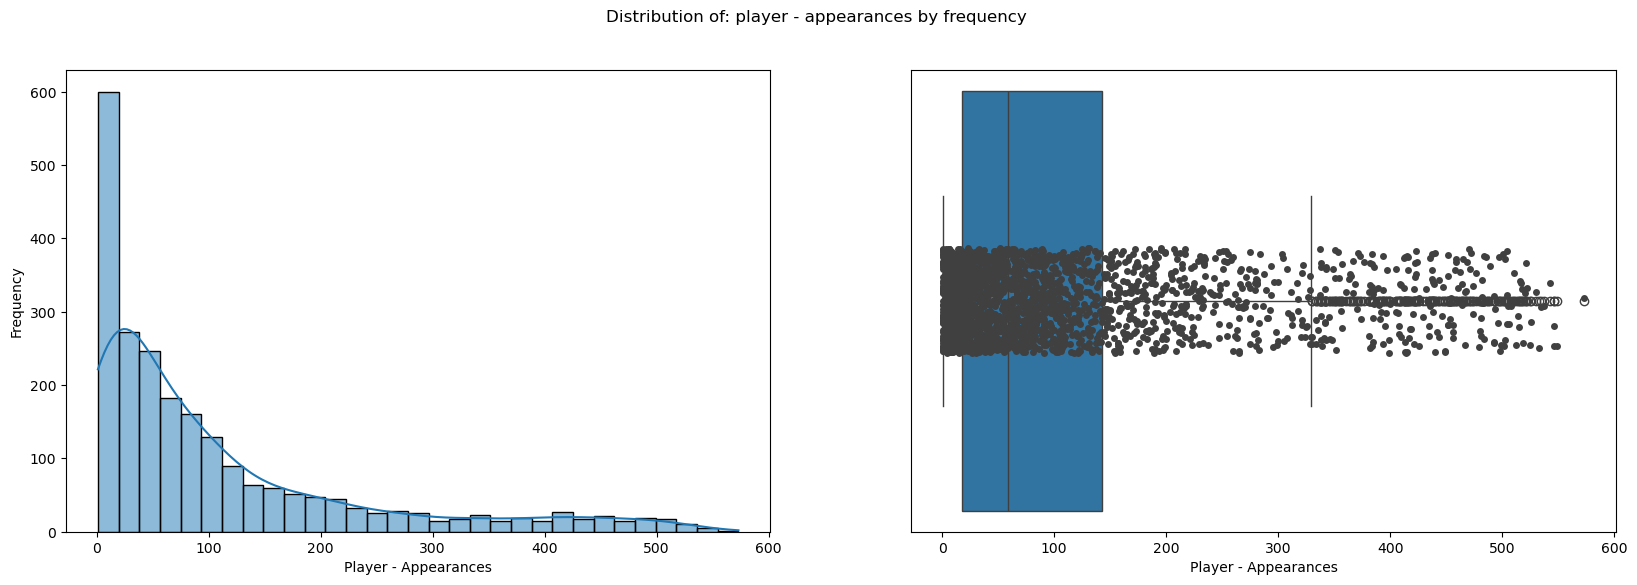

In [13]:
plot_distribution_by_variable(get_frequencies(cleaned_mlb_df, ["player_info__player_id"]), "frequency", "Player - Appearances", "Frequency")

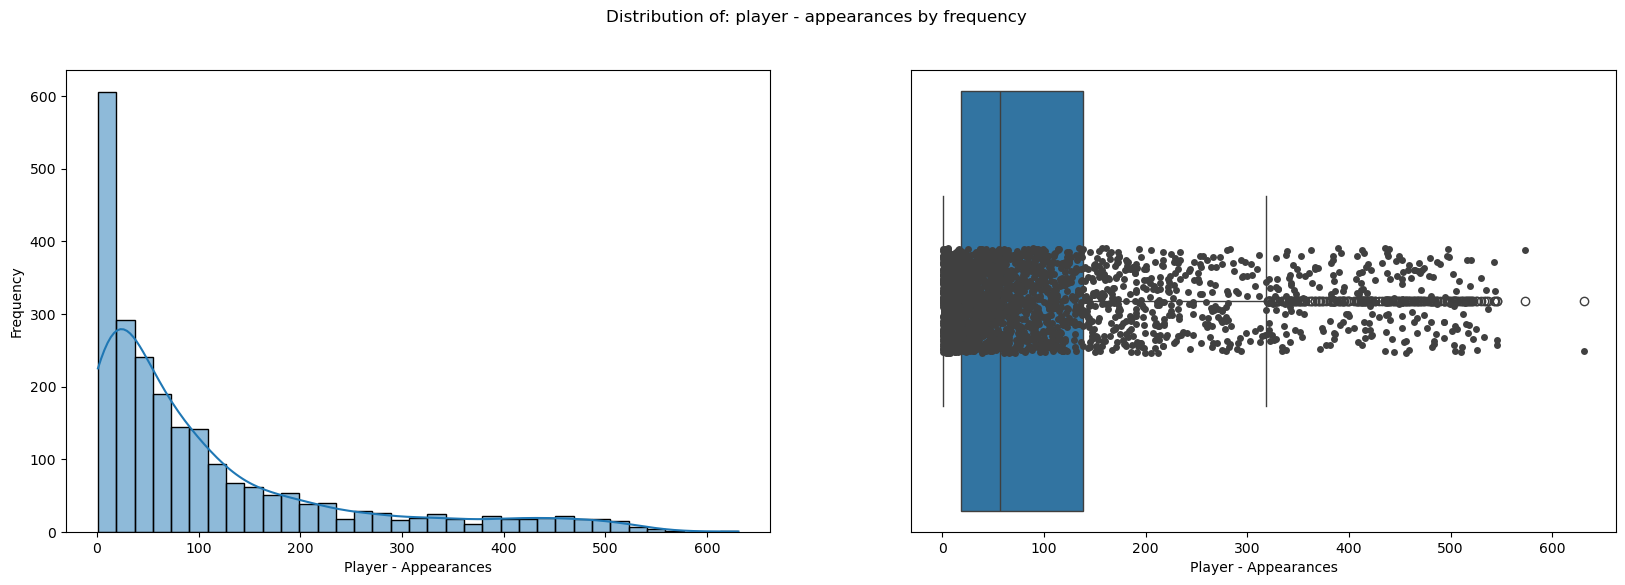

In [14]:
plot_distribution_by_variable(get_frequencies(cleaned_mlb_df, ["player_info__player_name"]), "frequency", "Player - Appearances", "Frequency")

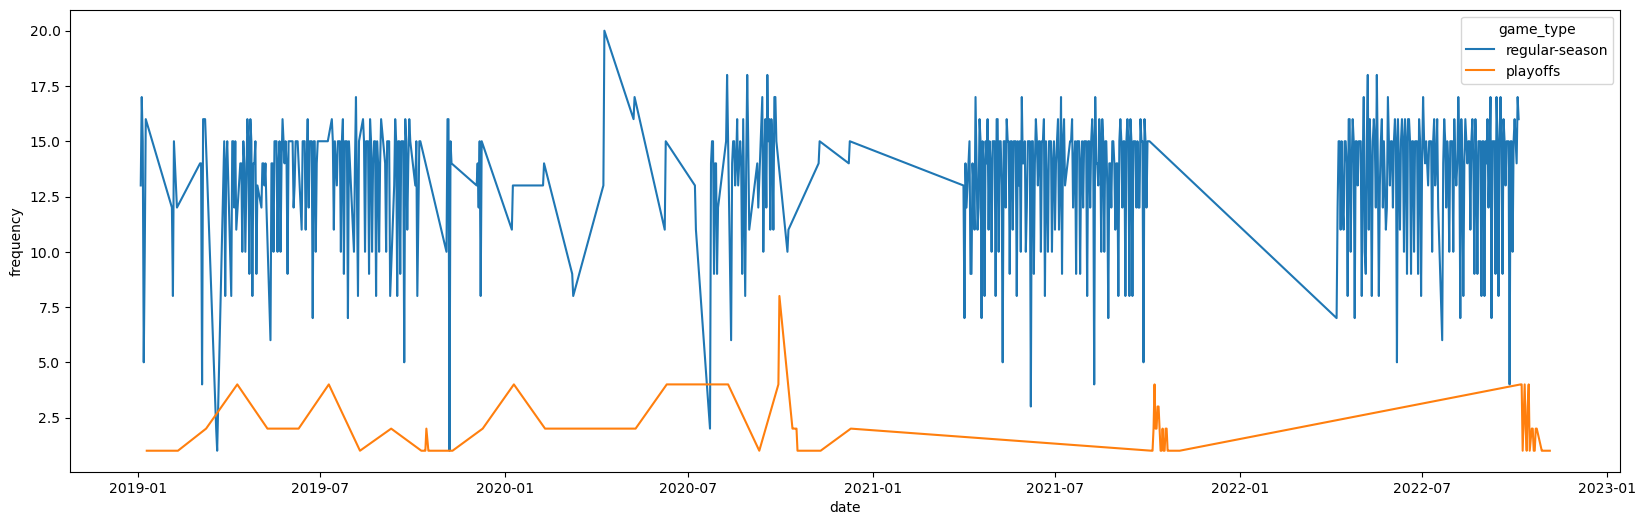

In [15]:
games_per_date = cleaned_mlb_df[["game_info__game_type", "game_info__game_id", "game_info__date"]].drop_duplicates()\
.groupby(["game_info__date", "game_info__game_type"])\
.size()\
.reset_index(name='frequency')\
.rename(columns={"game_info__date": "date", "game_info__game_type": "game_type"})

fig, ax = plt.subplots(figsize=(20, 6))

sns.lineplot(
    data=games_per_date,
    x="date",
    y="frequency",
    hue="game_type",
    ax=ax
)

plt.plot();

In [16]:
def plot_histogram(
    df: pd.DataFrame, 
    filter_column: str, 
    factor: Any, 
    value: str,
    kde: bool = False
) -> Figure:
    fig, ax = plt.subplots(ncols=1, figsize=(16, 8))

    sns.histplot(
        data=df[
        (df[filter_column] == factor) & (~df[value].isna())
        ], 
        x=value, 
        kde=kde,
        bins=100
    )
    ax.set_ylabel('Frecuency')
    ax.set_xlabel(" - ".join(value.split("__")))

    fig.suptitle(f'Distribution of: {value} by factor: {factor}')

    return fig

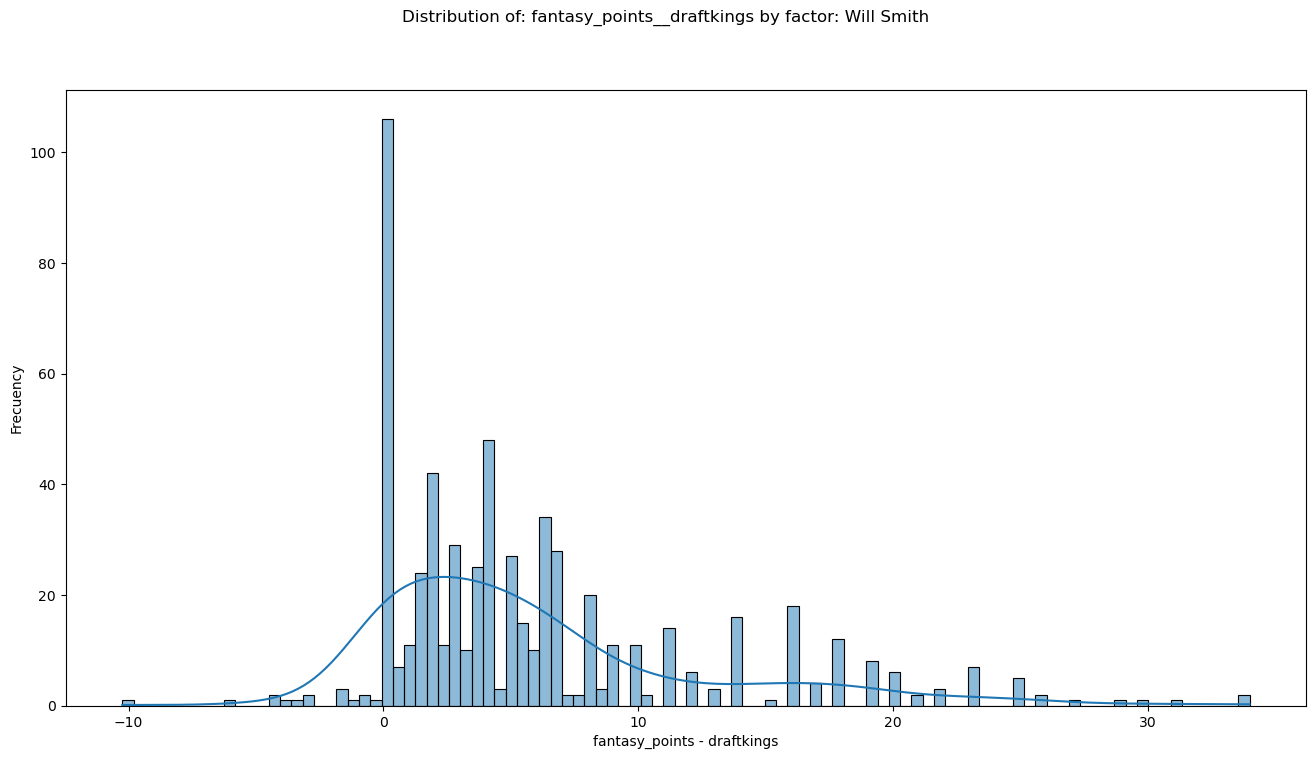

In [17]:
fig = plot_histogram(cleaned_mlb_df, "player_info__player_name", "Will Smith", "fantasy_points__draftkings", True)

## Position

In [18]:
get_frequencies(cleaned_mlb_df, ["position__fanduel"])

,position__fanduel,frequency
52,P,69587
42,OF,58807
31,C,19887
1,1B,17444
53,SS,15615
20,3B,15597
10,2B,14718
18,2B/SS,4035
17,2B/OF,2877
22,3B/2B,2163


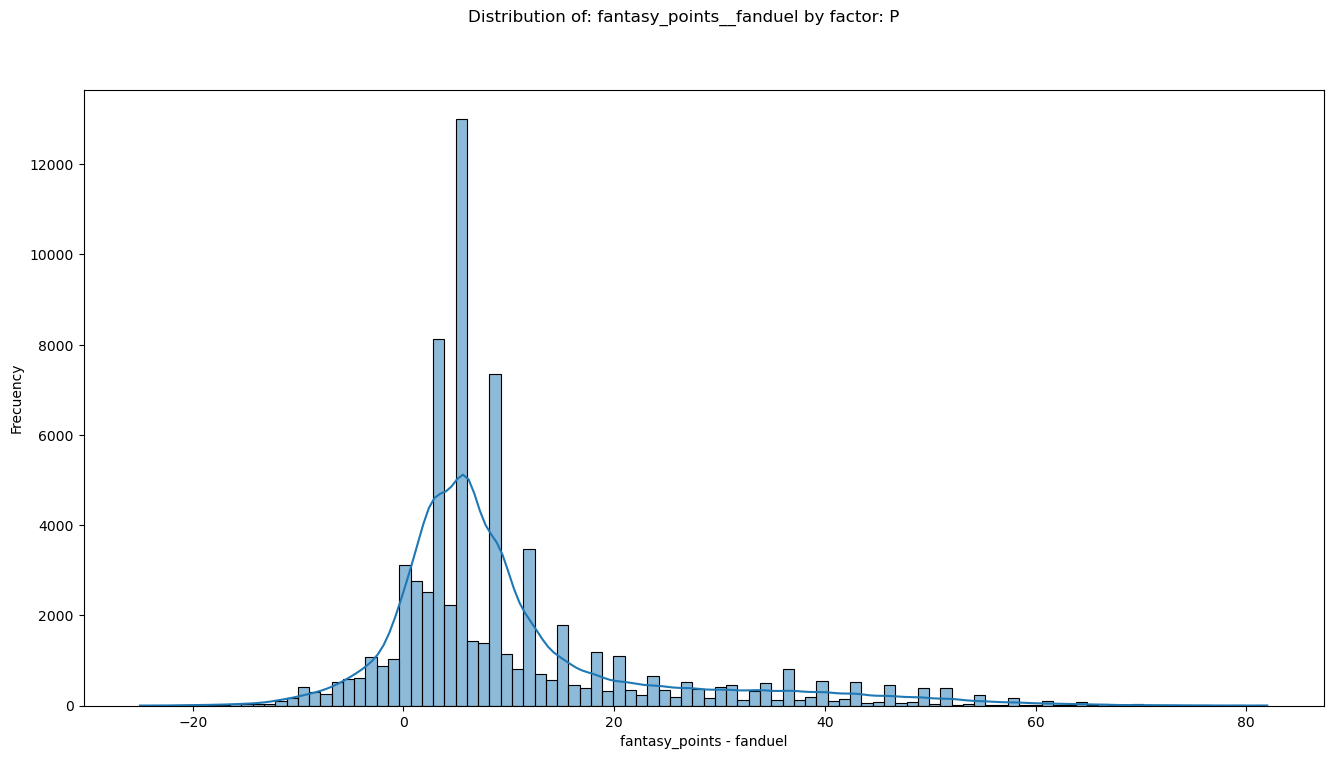

In [19]:
fig = plot_histogram(cleaned_mlb_df, "position__fanduel", "P", "fantasy_points__fanduel", True)

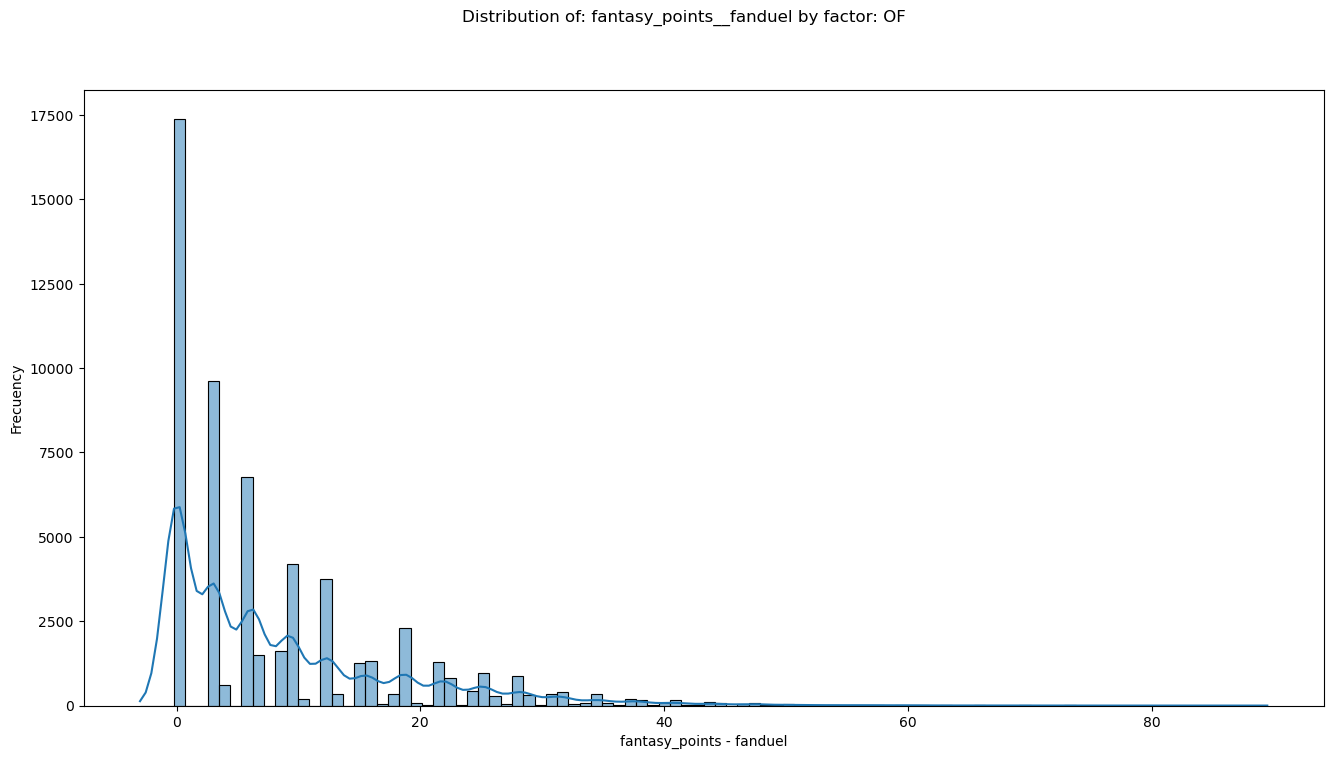

In [20]:
fig = plot_histogram(cleaned_mlb_df, "position__fanduel", "OF", "fantasy_points__fanduel", True)

# Distributions fitting process

## Fanduel for Pitchers

In [21]:
cleaned_mlb_df.head()

,game_info__bigdataball_dataset,game_info__game_id,game_info__date,player_info__player_id,player_info__player_name,player_info__team,player_info__opponent,player_info__venue,position__draftkings,position__fanduel,position__yahoo,salary__draftkings,salary__fanduel,salary__yahoo,fantasy_points__draftkings,fantasy_points__fanduel,fantasy_points__yahoo,game_info__game_type,year
0,MLB 2022 Regular Season,44658-MIL@CHC-1,2022-04-07,543939.0,Kolten Wong,Milwaukee Brewers,Chicago Cubs,Road,NaN,2B,NaN,NaN,2600.0,NaN,NaN,6.2,NaN,regular-season,2022
1,MLB 2022 Regular Season,44658-MIL@CHC-1,2022-04-07,642715.0,Willy Adames,Milwaukee Brewers,Chicago Cubs,Road,NaN,SS,NaN,NaN,2900.0,NaN,NaN,12.5,NaN,regular-season,2022
2,MLB 2022 Regular Season,44658-MIL@CHC-1,2022-04-07,592885.0,Christian Yelich,Milwaukee Brewers,Chicago Cubs,Road,NaN,OF,NaN,NaN,3300.0,NaN,NaN,6.5,NaN,regular-season,2022
3,MLB 2022 Regular Season,44658-MIL@CHC-1,2022-04-07,457705.0,Andrew McCutchen,Milwaukee Brewers,Chicago Cubs,Road,NaN,OF,NaN,NaN,2500.0,NaN,NaN,12.2,NaN,regular-season,2022
4,MLB 2022 Regular Season,44658-MIL@CHC-1,2022-04-07,642133.0,Rowdy Tellez,Milwaukee Brewers,Chicago Cubs,Road,NaN,C1B,NaN,NaN,2200.0,NaN,NaN,9.2,NaN,regular-season,2022


In [22]:
pitchers_df = cleaned_mlb_df[
    (cleaned_mlb_df.position__draftkings == "P") & 
    (~cleaned_mlb_df['fantasy_points__fanduel'].isna())
    ]

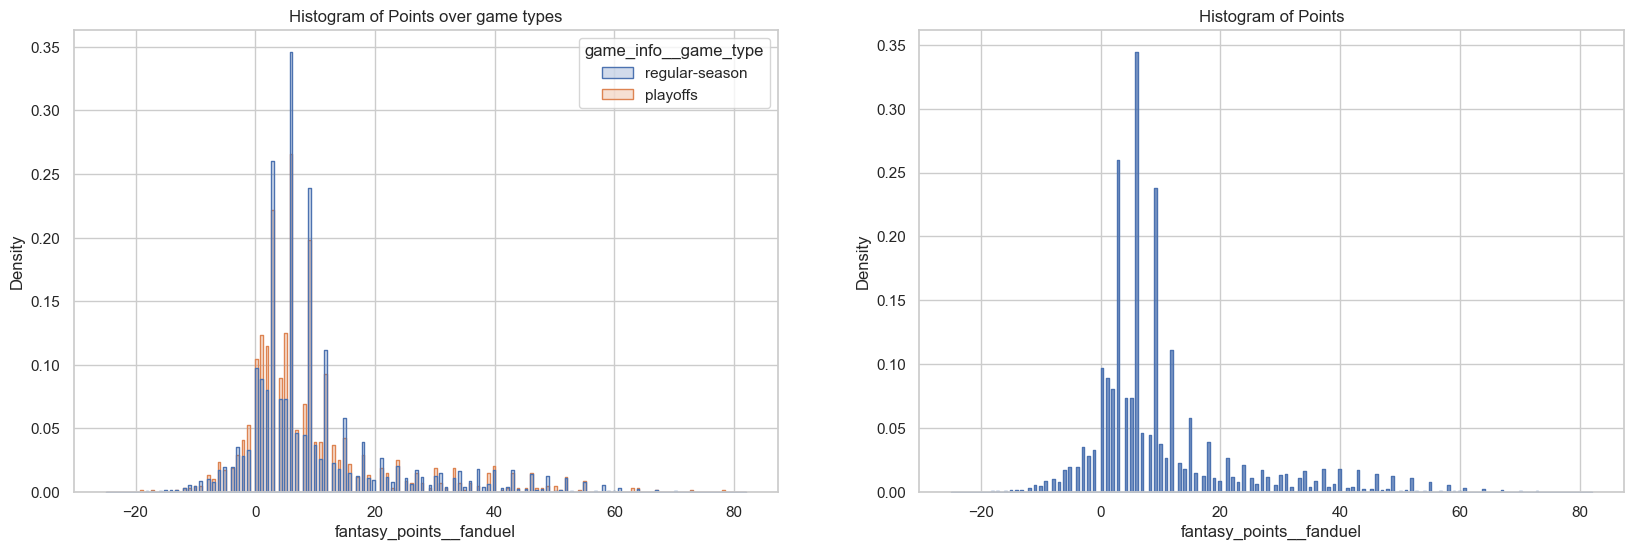

In [23]:
# Setting up style for better visualization
sns.set(style="whitegrid")

# Plotting the histogram
fig, ax = plt.subplots(ncols=2, figsize=(20, 6))

sns.histplot(
    data=pitchers_df, 
    x='fantasy_points__fanduel', 
    hue='game_info__game_type', 
    element='step', 
    stat='density', 
    common_norm=False, # Helps on visualization,
    ax=ax[0]
)

ax[0].set_title("Histogram of Points over game types")

sns.histplot(
    data=pitchers_df, 
    x='fantasy_points__fanduel', 
    element='step', 
    stat='density', 
    common_norm=False, # Helps on visualization,
    ax=ax[1]
)

ax[1].set_title('Histogram of Points')

plt.show()

### Adding more variables for categorizing players and don't assume a general distribution

In [24]:
statistics_by_pitcher = pitchers_df\
.groupby('player_info__player_id')\
.agg(number_of_observations=pd.NamedAgg("player_info__player_id", "count"))\
.sort_values(by=['number_of_observations'])\
.pipe(lambda df: df.assign(
    cumsum_observations=df.number_of_observations.cumsum(), 
    total_observations=df.number_of_observations.sum()
))\
.pipe(lambda df: df.assign(
    cumulative_proportion=(df.cumsum_observations / df.total_observations) * 100))\
.reset_index()\
.pipe(lambda df: df.assign(
    decile_group=pd.cut(df.cumulative_proportion, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
))

In [25]:
pitchers_df = pitchers_df.merge(right=statistics_by_pitcher)

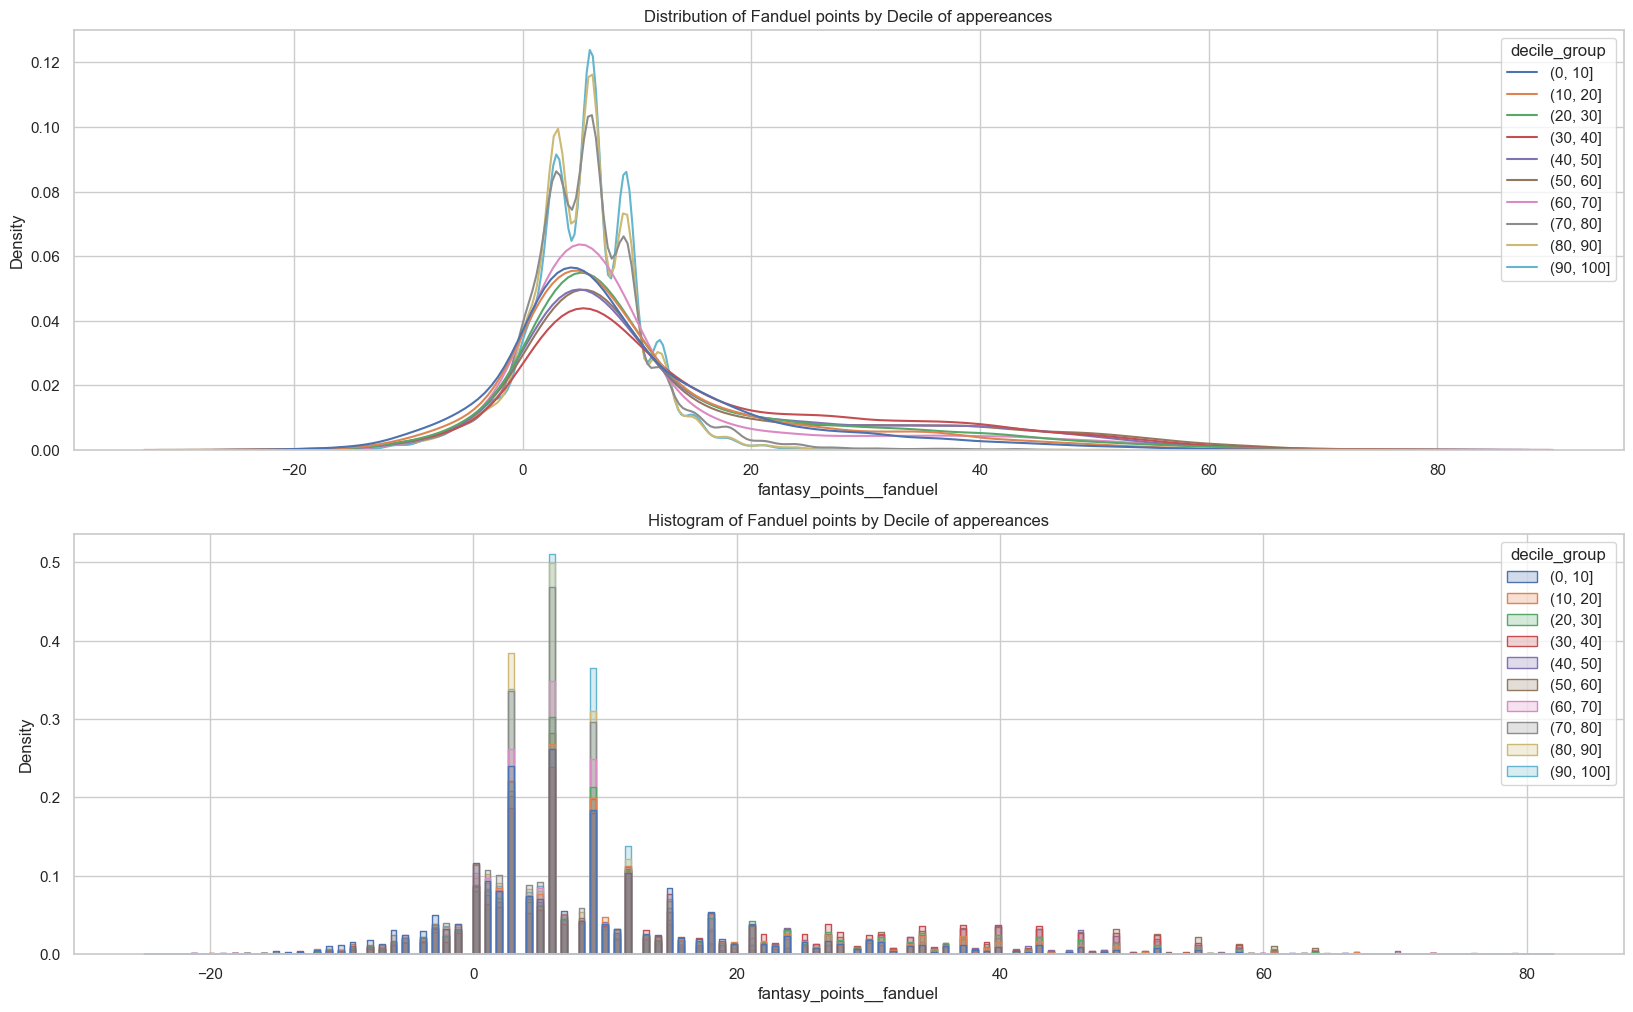

In [26]:
fig, ax = plt.subplots(nrows=2, figsize=(20, 12))

sns.kdeplot(
    data=pitchers_df, 
    x='fantasy_points__fanduel', 
    hue='decile_group', 
    common_norm=False,
    ax=ax[0],
)

ax[0].set_title('Distribution of Fanduel points by Decile of appereances')

sns.histplot(
    data=pitchers_df, 
    x='fantasy_points__fanduel', 
    element='step', 
    stat='density', 
    hue='decile_group', 
    common_norm=False, # Helps on visualization,
    ax=ax[1]
)

ax[1].set_title('Histogram of Fanduel points by Decile of appereances')

plt.show()

### Fitting a general distribution for all the population of pitchers

In [27]:
data = pitchers_df['fantasy_points__fanduel']

In [30]:
pitchers_distribution_fitter = DistributionFitter(
    distributions=[dist for dist in get_distributions() if dist not in ["levy_stable", "studentized_range", "erlang", "lognorm", "loguniform"]], 
    bins=sturges_bins(data)
)

In [31]:
pitchers_distribution_fitter.fit(data)

INFO:distribution_fitter:Fitting distribution: alpha
INFO:distribution_fitter:Fitting distribution: anglit
INFO:distribution_fitter:Fitting distribution: arcsine
INFO:distribution_fitter:Fitting distribution: argus
INFO:distribution_fitter:Fitting distribution: beta
/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
INFO:distribution_fitter:Fitting distribution: betaprime
INFO:distribution_fitter:Fitting distribution: bradford
INFO:distribution_fitter:Fitting distribution: burr
INFO:distribution_fitter:Fitting distribution: burr12
INFO:distribution_fitter:Fitting distribution: cauchy
INFO:distribution_fitter:Fitting distribution: chi
INFO:distribution_fitter:Fitting distribution: chi2
INFO:distribution_fitter:Fitting distribution: cosine
INFO:distribution_fitter:Fitting distribution: crystalball
INFO:distribution_fi

In [32]:
pitchers_distribution_fitter.summary(sort_by="ks_statistic", top_n=10)

,distribution,squared_error,aic,bic,kullberg_divergence,ks_statistic,ks_p_value,fitted_params
johnsonsu,johnsonsu,0.261252,3138.514162,3174.862009,inf,0.076855,0.0,"{'a': -0.7397766167090958, 'b': 0.872568120376..."
norminvgauss,norminvgauss,0.261025,3164.793302,3201.141149,inf,0.077840,0.0,"{'a': 0.5071916528765518, 'b': 0.3903092384162..."
nct,nct,0.261127,3165.863384,3202.211231,inf,0.080679,0.0,"{'df': 1.839282323025715, 'nc': 1.210312480973..."
genhyperbolic,genhyperbolic,0.262075,3131.491843,3176.926652,inf,0.080898,0.0,"{'p': -0.005989684523998585, 'a': 0.3487107208..."
skewcauchy,skewcauchy,0.261328,3049.995862,3077.256748,inf,0.092590,0.0,"{'a': 0.4443709805713911, 'loc': 3.23475751284..."
t,t,0.262327,3218.164550,3245.425435,inf,0.109563,0.0,"{'df': 1.469173694817656, 'loc': 6.00876240288..."
loglaplace,loglaplace,0.260357,3357.732436,3384.993321,inf,0.110175,0.0,"{'c': 4.5353401344562085, 'loc': -25.073365189..."
tukeylambda,tukeylambda,0.262379,3211.339183,3238.600068,inf,0.110866,0.0,"{'lam': -0.5616034558055945, 'loc': 5.99026507..."
dgamma,dgamma,0.249253,3550.338687,3577.599572,inf,0.114746,0.0,"{'a': 0.8190707446836589, 'loc': 6.00000000000..."
laplace_asymmetric,laplace_asymmetric,0.262761,3277.337308,3304.598193,inf,0.115484,0.0,"{'kappa': 0.585114851862595, 'loc': 2.99999999..."


#### Validation

In [40]:
def plot_ecdf(ax: plt.Axes, theoretical_data: np.ndarray, sample_data: np.ndarray, **kwargs) -> plt.Axes:
    title = kwargs.get('title', 'ECDF Plot for Goodness of Fit')
    
    sns.ecdfplot(theoretical_data, label='Theoretical Data', ax=ax)
    sns.ecdfplot(sample_data, label='Theoretical Data', ax=ax)
    ax.set_title(title)
    return ax 

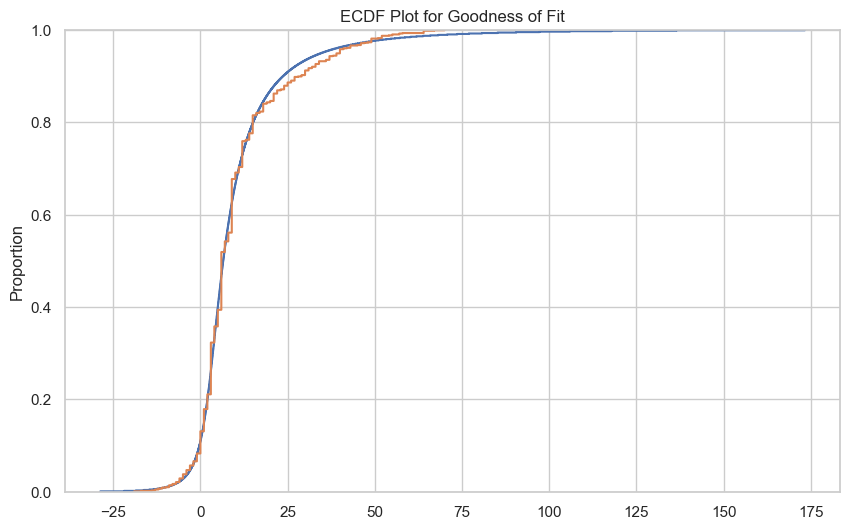

In [41]:
sample_data = np.random.choice(data, size=1000)
theoretical_distribution = pitchers_distribution_fitter.get_distribution("johnsonsu")
theoretical_data = theoretical_distribution.ppf(np.linspace(0.001, 0.999, len(sample_data)))

fig, ax = plt.subplots(figsize=(10, 6))

_ = plot_ecdf(ax=ax, theoretical_data=theoretical_data, sample_data=sample_data)

In [ ]:
# fit a cdf

sample_data = np.random.choice(data, size=1000)
theoretical_distribution = distribution_fitter.get_distribution("johnsonsu")
theoretical_data = theoretical_distribution.ppf(np.linspace(0.001, 0.999, len(sample_data)))

ecdf = ECDF(sample_data)
ecdf_theoretical = ECDF(theoretical_data)
# get cumulative probability for values
print('P(x<20): %.3f' % ecdf(20))
print('P(x<40): %.3f' % ecdf(40))
print('P(x<60): %.3f' % ecdf(60))
# plot the cdf
plt.plot(ecdf.x, ecdf.y, color='r')
plt.plot(ecdf_theoretical.x, ecdf_theoretical.y, color='g')
plt.show()

In [ ]:
theoretical_distribution = distribution_fitter.get_distribution("johnsonsu")

In [ ]:
sample_data = np.random.choice(data, size=1000)

In [ ]:
1000 / len(data)

In [ ]:
theoretical_data = theoretical_distribution.ppf(np.linspace(0.001, 0.999, len(sample_data)))

In [ ]:
player_appereances = cleaned_mlb_df[
(cleaned_mlb_df.position__draftkings == "P") & 
(~cleaned_mlb_df['fantasy_points__fanduel'].isna())
]\
.groupby('player_info__player_id')\
.agg(frequency=pd.NamedAgg("player_info__player_id", "count"))\
.sort_values(by=['frequency'])


player_appereances = player_appereances.assign(
    cumsum_games=player_appereances.frequency.cumsum(), 
    total_games=player_appereances.frequency.sum()
).pipe(lambda df: df.assign(proportion=(df.cumsum_games / df.total_games) * 100))\
.reset_index()

player_appereances = player_appereances.assign(
    decile_group=pd.cut(player_appereances['proportion'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
)

player_appereances.head()

In [ ]:
plt.figure(figsize=(10, 10))

sns.kdeplot(
    data = cleaned_mlb_df[
    (cleaned_mlb_df.position__draftkings == "P") & 
    (~cleaned_mlb_df['fantasy_points__fanduel'].isna())
].merge(right=player_appereances, how="inner"), x="fantasy_points__fanduel", 
    hue="decile_group"
)

In [ ]:
theoretical_data = np.sort(theoretical_data)
sample_data = np.sort(sample_data)
sample_data_theoretical = scipy.stats.johnsonsu.rvs(**dist_test, random_state=None, size=len(sample_data))

In [ ]:
sns.histplot(theoretical_data, label="Drawn from the distribution")
sns.histplot(sample_data, label="real data")
sns.histplot(sample_data_theoretical, label="Drawn from the theoretical ")

plt.legend()

In [ ]:
# Create a QQ plot
plt.figure(figsize=(8, 6))
plt.scatter(theorical_data, sample_data, c='b', marker='o')
plt.plot([np.min(sample_data), np.max(sample_data)], [np.min(sample_data), np.max(sample_data)], color='r', linestyle='--')
plt.title('QQ Plot for Goodness of Fit')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

In [ ]:
class DistributionValidator:
    def __init__(self, distribution_fitter: DistributionFitter, data: np.ndarray) -> None:
        self.fitter = distribution_fitter
        self.data = data
        
    def validate_goodness_of_fit(self, distribution_name: str, sample_proportion: float = 0.01) -> None:
        sample_size = int(np.ceil(self.fitter._data.size * sample_proportion))
        
        sample_data = np.random.choice(self.fitter._data, size=sample_size)
        theoretical_distribution = self.fitter.get_distribution(distribution_name=distribution_name)
        theoretical_data = theoretical_distribution.ppf(np.linspace(0.001, 0.999, len(sample_data)))
        
        theoretical_data = np.sort(theoretical_data)
        sample_data = np.sort(sample_data)
        
        return theoretical_data, sample_data
        
        
    @staticmethod
    def _qq_plot(ax: plt.Axes, theoretical_data: np.ndarray, sample_data: np.ndarray, **kwargs) -> plt.Axes:
        
        ax.scatter(x=theoretical_data, y=sample_data, c='b', marker='o', **kwargs)
        ax.plot([np.min(sample_data), np.max(sample_data)], [np.min(sample_data), np.max(sample_data)], color='r', linestyle='--')
        ax.title('QQ Plot for Goodness of Fit')
        # ax.xlabel('Theoretical Quantiles')
        # ax.ylabel('Sample Quantiles')
        # ax.grid(True)
        
        return ax

In [ ]:
validator = DistributionValidator(distribution_fitter=distribution_fitter, data=data)

In [ ]:
t_data, s_data = validator.validate_goodness_of_fit("johnsonsu", 0.0153)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6), ncols=2)

validator._qq_plot(ax=ax[0], theoretical_data=t_data, sample_data=s_data)

# Sample data
sample_data = np.random.normal(9.332075471698113, 12.499234294810549, 100)

# Define a theoretical distribution (e.g., the standard normal distribution)
theoretical_distribution = scipy.stats.norm

# Generate the quantiles for the theoretical distribution
theoretical_quantiles = theoretical_distribution.ppf(np.linspace(0.01, 0.99, 100), loc=9.332075471698113, scale=12.499234294810549)

# Sort the sample data
sample_data.sort()

# Create a QQ plot
plt.figure(figsize=(8, 6))
plt.scatter(theoretical_quantiles, sample_data, c='b', marker='o')
plt.plot([np.min(sample_data), np.max(sample_data)], [np.min(sample_data), np.max(sample_data)], color='r', linestyle='--')
plt.title('QQ Plot for Goodness of Fit')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()